## watermark training

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy
print("PyTorch Version: ",torch.__version__)
print("Torchvision Version: ",torchvision.__version__)
from PIL import Image
import pandas as pd
import random
from tqdm import tqdm
import timm

import sys
sys.path.append('../')
from watermarkmodel.model.convnext import convnext_tiny
from watermarkmodel.model.dataset import WatermarkDataset
from watermarkmodel.model.preprocess import RandomRotation
from watermarkmodel.model.train import train_model

input_size = 256

/Users/atsiri/.pyenv/versions/3.9.13/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


PyTorch Version:  2.2.2
Torchvision Version:  0.17.2
PyTorch Version:  2.2.2
Torchvision Version:  0.17.2


/Users/atsiri/.pyenv/versions/3.9.13/lib/python3.9/site-packages/timm/models/layers/__init__.py:48: FutureWarning: Importing from timm.models.layers is deprecated, please import via timm.layers
  warnings.warn(f"Importing from {__name__} is deprecated, please import via timm.layers", FutureWarning)
/Users/atsiri/.pyenv/versions/3.9.13/lib/python3.9/site-packages/timm/models/registry.py:4: FutureWarning: Importing from timm.models.registry is deprecated, please import via timm.models
  warnings.warn(f"Importing from {__name__} is deprecated, please import via timm.models", FutureWarning)


**ConvNext**

In [2]:
from watermarkmodel.model.convnext import convnext_tiny

model_ft = convnext_tiny(pretrained=True, in_22k=True, num_classes=21841)

model_ft.head = nn.Sequential( 
    nn.Linear(in_features=768, out_features=512),
    nn.GELU(),
    nn.Linear(in_features=512, out_features=256),
    nn.GELU(),
    nn.Linear(in_features=256, out_features=2),
)

**Preprocessing**

- Device Setting

In [3]:
#using cpu when gpu is not available
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model_ft = model_ft.to(device)

- Dataset Preparation

In [4]:
from watermarkmodel.model.preprocess import Preprocessing
import pandas as pd

#read dataset
df_train = pd.read_csv('../dataset/train_data_v1.csv')
df_val = pd.read_csv('../dataset/val_data_v1.csv')

datasets = Preprocessing(df_train, df_val)
datasets

{'train': <watermarkmodel.model.dataset.WatermarkDataset at 0x10e364760>,
 'val': <watermarkmodel.model.dataset.WatermarkDataset at 0x129c78670>}

**Data Training**

In [13]:
def train_model_hyperparameter(df_train, df_val, batch, lrate, epoch):
    datasets = Preprocessing(df_train, df_val)

    model_ft = convnext_tiny(pretrained=True, in_22k=True, num_classes=21841)
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    BATCH_SIZE = int(batch)
    #config
    criterion = torch.nn.CrossEntropyLoss()
    optimizer = optim.AdamW(params=model_ft.parameters(), lr=lrate)
    dataloaders_dict = {
        x: torch.utils.data.DataLoader(datasets[x], batch_size=BATCH_SIZE, shuffle=True, num_workers=0) #to prevent runtimeerror on non gpu device
        for x in ['train', 'val']
    }

    #train
    model_ft.head = nn.Sequential( 
        nn.Linear(in_features=768, out_features=512),
        nn.GELU(),
        nn.Linear(in_features=512, out_features=256),
        nn.GELU(),
        nn.Linear(in_features=256, out_features=2),
    )

    model_ft, train_acc_history, val_acc_history = train_model(
        model_ft, dataloaders_dict, criterion, optimizer, num_epochs=epoch
    )

    #save model
    #filename = 'watermark_model.pkl'
    return model_ft, train_acc_history, val_acc_history

**training with provided data**

In [14]:
from sklearn.utils.extmath import cartesian

batches = [8, 16, 32, 64]
lrates = [0.1e-3, 0.1e-5]
epoch = list(map(int, [5, 10]))
df_params = pd.DataFrame(cartesian((batches, lrates)), columns=['batch', 'lrate'])
df_params

,batch,lrate
0,8.0,0.000100
1,8.0,0.000001
2,16.0,0.000100
3,16.0,0.000001
4,32.0,0.000100
5,32.0,0.000001
6,64.0,0.000100
7,64.0,0.000001


In [15]:
models, train_accs, val_accs, avg_train, avg_val = [], [], [], [], []
for i, rows in df_params.iterrows():
    model, train_acc, val_acc = train_model_hyperparameter(df_train, df_val, rows.batch, rows.lrate, 10)
    avg_train.append(torch.mean(torch.tensor(train_acc)))
    avg_val.append(torch.mean(torch.tensor(val_acc)))
    models.append(model)
    train_accs.append(train_acc)
    val_accs.append(val_acc)

print('done')

Epoch 0/9
----------


  0%|          | 0/14 [00:00<?, ?it/s]/Users/atsiri/.pyenv/versions/3.9.13/lib/python3.9/site-packages/torch/amp/autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
100%|██████████| 14/14 [01:16<00:00,  5.44s/it]


train Loss: 0.6381 Acc: 0.6875


100%|██████████| 2/2 [00:02<00:00,  1.44s/it]


val Loss: 0.5334 Acc: 0.7143

Epoch 1/9
----------


100%|██████████| 14/14 [01:03<00:00,  4.53s/it]


train Loss: 0.4312 Acc: 0.7321


100%|██████████| 2/2 [00:01<00:00,  1.03it/s]


val Loss: 0.3478 Acc: 0.9286

Epoch 2/9
----------


100%|██████████| 14/14 [01:06<00:00,  4.72s/it]


train Loss: 0.2708 Acc: 0.9464


100%|██████████| 2/2 [00:01<00:00,  1.11it/s]


val Loss: 0.2450 Acc: 0.9286

Epoch 3/9
----------


100%|██████████| 14/14 [00:57<00:00,  4.10s/it]


train Loss: 0.1969 Acc: 0.9732


100%|██████████| 2/2 [00:01<00:00,  1.43it/s]


val Loss: 0.2012 Acc: 0.9286

Epoch 4/9
----------


100%|██████████| 14/14 [00:48<00:00,  3.47s/it]


train Loss: 0.1971 Acc: 0.9643


100%|██████████| 2/2 [00:01<00:00,  1.19it/s]


val Loss: 0.2335 Acc: 0.8571

Epoch 5/9
----------


100%|██████████| 14/14 [00:48<00:00,  3.48s/it]


train Loss: 0.2860 Acc: 0.9375


100%|██████████| 2/2 [00:01<00:00,  1.45it/s]


val Loss: 0.2747 Acc: 0.9286

Epoch 6/9
----------


100%|██████████| 14/14 [00:45<00:00,  3.27s/it]


train Loss: 0.1575 Acc: 0.9732


100%|██████████| 2/2 [00:01<00:00,  1.47it/s]


val Loss: 0.4903 Acc: 0.7857

Epoch 7/9
----------


100%|██████████| 14/14 [00:44<00:00,  3.19s/it]


train Loss: 0.0747 Acc: 1.0000


100%|██████████| 2/2 [00:01<00:00,  1.47it/s]


val Loss: 0.1185 Acc: 0.9286

Epoch 8/9
----------


100%|██████████| 14/14 [00:44<00:00,  3.21s/it]


train Loss: 0.0573 Acc: 1.0000


100%|██████████| 2/2 [00:01<00:00,  1.48it/s]


val Loss: 0.0628 Acc: 1.0000

Epoch 9/9
----------


100%|██████████| 14/14 [00:46<00:00,  3.35s/it]


train Loss: 0.0593 Acc: 0.9911


100%|██████████| 2/2 [00:01<00:00,  1.42it/s]


val Loss: 0.2106 Acc: 0.9286

Training complete in 9m 19s
Best val Acc: 1.000000
Epoch 0/9
----------


100%|██████████| 14/14 [00:46<00:00,  3.32s/it]


train Loss: 0.6817 Acc: 0.6786


100%|██████████| 2/2 [00:01<00:00,  1.48it/s]


val Loss: 0.6759 Acc: 0.7143

Epoch 1/9
----------


100%|██████████| 14/14 [00:45<00:00,  3.22s/it]


train Loss: 0.6784 Acc: 0.6964


100%|██████████| 2/2 [00:01<00:00,  1.47it/s]


val Loss: 0.6731 Acc: 0.7143

Epoch 2/9
----------


100%|██████████| 14/14 [00:44<00:00,  3.21s/it]


train Loss: 0.6758 Acc: 0.7143


100%|██████████| 2/2 [00:01<00:00,  1.48it/s]


val Loss: 0.6704 Acc: 0.7143

Epoch 3/9
----------


100%|██████████| 14/14 [00:45<00:00,  3.27s/it]


train Loss: 0.6747 Acc: 0.7143


100%|██████████| 2/2 [00:01<00:00,  1.47it/s]


val Loss: 0.6677 Acc: 0.7143

Epoch 4/9
----------


100%|██████████| 14/14 [00:47<00:00,  3.40s/it]


train Loss: 0.6711 Acc: 0.7143


100%|██████████| 2/2 [00:01<00:00,  1.42it/s]


val Loss: 0.6653 Acc: 0.7143

Epoch 5/9
----------


100%|██████████| 14/14 [00:47<00:00,  3.38s/it]


train Loss: 0.6680 Acc: 0.7143


100%|██████████| 2/2 [00:01<00:00,  1.55it/s]


val Loss: 0.6628 Acc: 0.7143

Epoch 6/9
----------


100%|██████████| 14/14 [00:43<00:00,  3.12s/it]


train Loss: 0.6670 Acc: 0.7054


100%|██████████| 2/2 [00:01<00:00,  1.65it/s]


val Loss: 0.6604 Acc: 0.7143

Epoch 7/9
----------


100%|██████████| 14/14 [00:46<00:00,  3.36s/it]


train Loss: 0.6648 Acc: 0.7054


100%|██████████| 2/2 [00:01<00:00,  1.64it/s]


val Loss: 0.6582 Acc: 0.7143

Epoch 8/9
----------


100%|██████████| 14/14 [00:41<00:00,  2.93s/it]


train Loss: 0.6613 Acc: 0.7054


100%|██████████| 2/2 [00:01<00:00,  1.65it/s]


val Loss: 0.6561 Acc: 0.7143

Epoch 9/9
----------


100%|██████████| 14/14 [00:41<00:00,  2.99s/it]


train Loss: 0.6595 Acc: 0.7054


100%|██████████| 2/2 [00:01<00:00,  1.61it/s]


val Loss: 0.6540 Acc: 0.7143

Training complete in 7m 44s
Best val Acc: 0.714286
Epoch 0/9
----------


100%|██████████| 7/7 [00:42<00:00,  6.07s/it]


train Loss: 0.6495 Acc: 0.6875


100%|██████████| 1/1 [00:01<00:00,  1.19s/it]


val Loss: 0.5810 Acc: 0.7143

Epoch 1/9
----------


100%|██████████| 7/7 [00:40<00:00,  5.84s/it]


train Loss: 0.5500 Acc: 0.7054


100%|██████████| 1/1 [00:01<00:00,  1.21s/it]


val Loss: 0.4961 Acc: 0.7143

Epoch 2/9
----------


100%|██████████| 7/7 [00:43<00:00,  6.17s/it]


train Loss: 0.4262 Acc: 0.7054


100%|██████████| 1/1 [00:01<00:00,  1.18s/it]


val Loss: 0.3760 Acc: 0.7143

Epoch 3/9
----------


100%|██████████| 7/7 [00:40<00:00,  5.81s/it]


train Loss: 0.3481 Acc: 0.7768


100%|██████████| 1/1 [00:01<00:00,  1.40s/it]


val Loss: 0.3341 Acc: 0.9286

Epoch 4/9
----------


100%|██████████| 7/7 [00:40<00:00,  5.79s/it]


train Loss: 0.2978 Acc: 0.9643


100%|██████████| 1/1 [00:01<00:00,  1.39s/it]


val Loss: 0.3004 Acc: 0.9286

Epoch 5/9
----------


100%|██████████| 7/7 [00:39<00:00,  5.68s/it]


train Loss: 0.2374 Acc: 0.9821


100%|██████████| 1/1 [00:01<00:00,  1.17s/it]


val Loss: 0.3472 Acc: 0.9286

Epoch 6/9
----------


100%|██████████| 7/7 [00:40<00:00,  5.73s/it]


train Loss: 0.2138 Acc: 0.9821


100%|██████████| 1/1 [00:01<00:00,  1.35s/it]


val Loss: 0.2696 Acc: 0.8571

Epoch 7/9
----------


100%|██████████| 7/7 [00:39<00:00,  5.59s/it]


train Loss: 0.1749 Acc: 0.9821


100%|██████████| 1/1 [00:01<00:00,  1.16s/it]


val Loss: 0.2265 Acc: 0.9286

Epoch 8/9
----------


100%|██████████| 7/7 [00:39<00:00,  5.62s/it]


train Loss: 0.1476 Acc: 0.9821


100%|██████████| 1/1 [00:01<00:00,  1.19s/it]


val Loss: 0.2706 Acc: 0.8571

Epoch 9/9
----------


100%|██████████| 7/7 [00:39<00:00,  5.70s/it]


train Loss: 0.1245 Acc: 0.9911


100%|██████████| 1/1 [00:01<00:00,  1.16s/it]


val Loss: 0.3065 Acc: 0.8571

Training complete in 6m 58s
Best val Acc: 0.928571
Epoch 0/9
----------


100%|██████████| 7/7 [00:41<00:00,  5.87s/it]


train Loss: 0.6951 Acc: 0.4821


100%|██████████| 1/1 [00:01<00:00,  1.16s/it]


val Loss: 0.6921 Acc: 0.5714

Epoch 1/9
----------


100%|██████████| 7/7 [00:39<00:00,  5.65s/it]


train Loss: 0.6937 Acc: 0.5446


100%|██████████| 1/1 [00:01<00:00,  1.19s/it]


val Loss: 0.6905 Acc: 0.6429

Epoch 2/9
----------


100%|██████████| 7/7 [00:41<00:00,  5.96s/it]


train Loss: 0.6911 Acc: 0.5804


100%|██████████| 1/1 [00:01<00:00,  1.20s/it]


val Loss: 0.6890 Acc: 0.5714

Epoch 3/9
----------


100%|██████████| 7/7 [00:39<00:00,  5.70s/it]


train Loss: 0.6887 Acc: 0.6250


100%|██████████| 1/1 [00:01<00:00,  1.23s/it]


val Loss: 0.6874 Acc: 0.6429

Epoch 4/9
----------


100%|██████████| 7/7 [00:39<00:00,  5.70s/it]


train Loss: 0.6881 Acc: 0.5804


100%|██████████| 1/1 [00:01<00:00,  1.19s/it]


val Loss: 0.6858 Acc: 0.6429

Epoch 5/9
----------


100%|██████████| 7/7 [00:41<00:00,  5.97s/it]


train Loss: 0.6867 Acc: 0.6250


100%|██████████| 1/1 [00:01<00:00,  1.17s/it]


val Loss: 0.6841 Acc: 0.6429

Epoch 6/9
----------


100%|██████████| 7/7 [00:40<00:00,  5.72s/it]


train Loss: 0.6831 Acc: 0.6607


100%|██████████| 1/1 [00:01<00:00,  1.23s/it]


val Loss: 0.6827 Acc: 0.7143

Epoch 7/9
----------


100%|██████████| 7/7 [00:41<00:00,  5.88s/it]


train Loss: 0.6820 Acc: 0.6786


100%|██████████| 1/1 [00:01<00:00,  1.18s/it]


val Loss: 0.6813 Acc: 0.7143

Epoch 8/9
----------


100%|██████████| 7/7 [00:52<00:00,  7.57s/it]


train Loss: 0.6816 Acc: 0.6875


100%|██████████| 1/1 [00:01<00:00,  1.49s/it]


val Loss: 0.6797 Acc: 0.7143

Epoch 9/9
----------


100%|██████████| 7/7 [00:44<00:00,  6.29s/it]


train Loss: 0.6799 Acc: 0.6696


100%|██████████| 1/1 [00:01<00:00,  1.74s/it]


val Loss: 0.6782 Acc: 0.7143

Training complete in 7m 15s
Best val Acc: 0.714286
Epoch 0/9
----------


100%|██████████| 4/4 [01:00<00:00, 15.24s/it]


train Loss: 0.6688 Acc: 0.6786


100%|██████████| 1/1 [00:01<00:00,  1.67s/it]


val Loss: 0.5848 Acc: 0.7143

Epoch 1/9
----------


100%|██████████| 4/4 [00:57<00:00, 14.39s/it]


train Loss: 0.5716 Acc: 0.7054


100%|██████████| 1/1 [00:01<00:00,  1.34s/it]


val Loss: 0.5305 Acc: 0.7143

Epoch 2/9
----------


100%|██████████| 4/4 [00:58<00:00, 14.57s/it]


train Loss: 0.4854 Acc: 0.7143


100%|██████████| 1/1 [00:01<00:00,  1.82s/it]


val Loss: 0.4543 Acc: 0.8571

Epoch 3/9
----------


100%|██████████| 4/4 [00:59<00:00, 14.94s/it]


train Loss: 0.3952 Acc: 0.8661


100%|██████████| 1/1 [00:01<00:00,  1.41s/it]


val Loss: 0.3831 Acc: 0.9286

Epoch 4/9
----------


100%|██████████| 4/4 [00:58<00:00, 14.61s/it]


train Loss: 0.3297 Acc: 0.9732


100%|██████████| 1/1 [00:01<00:00,  1.28s/it]


val Loss: 0.3508 Acc: 0.8571

Epoch 5/9
----------


100%|██████████| 4/4 [01:03<00:00, 15.77s/it]


train Loss: 0.2833 Acc: 0.9643


100%|██████████| 1/1 [00:01<00:00,  1.50s/it]


val Loss: 0.3236 Acc: 0.8571

Epoch 6/9
----------


100%|██████████| 4/4 [01:05<00:00, 16.37s/it]


train Loss: 0.2444 Acc: 0.9911


100%|██████████| 1/1 [00:01<00:00,  1.32s/it]


val Loss: 0.3294 Acc: 0.8571

Epoch 7/9
----------


100%|██████████| 4/4 [01:03<00:00, 15.97s/it]


train Loss: 0.2331 Acc: 0.9732


100%|██████████| 1/1 [00:01<00:00,  1.39s/it]


val Loss: 0.3150 Acc: 0.8571

Epoch 8/9
----------


100%|██████████| 4/4 [01:06<00:00, 16.67s/it]


train Loss: 0.2054 Acc: 0.9821


100%|██████████| 1/1 [00:01<00:00,  1.30s/it]


val Loss: 0.3702 Acc: 0.8571

Epoch 9/9
----------


100%|██████████| 4/4 [00:55<00:00, 13.80s/it]


train Loss: 0.1681 Acc: 1.0000


100%|██████████| 1/1 [00:01<00:00,  1.23s/it]


val Loss: 0.3745 Acc: 0.8571

Training complete in 10m 24s
Best val Acc: 0.928571
Epoch 0/9
----------


100%|██████████| 4/4 [00:57<00:00, 14.46s/it]


train Loss: 0.6805 Acc: 0.7054


100%|██████████| 1/1 [00:01<00:00,  1.19s/it]


val Loss: 0.6845 Acc: 0.6429

Epoch 1/9
----------


100%|██████████| 4/4 [00:54<00:00, 13.73s/it]


train Loss: 0.6802 Acc: 0.7143


100%|██████████| 1/1 [00:01<00:00,  1.16s/it]


val Loss: 0.6836 Acc: 0.7143

Epoch 2/9
----------


100%|██████████| 4/4 [01:06<00:00, 16.54s/it]


train Loss: 0.6784 Acc: 0.7143


100%|██████████| 1/1 [00:01<00:00,  1.27s/it]


val Loss: 0.6829 Acc: 0.7143

Epoch 3/9
----------


100%|██████████| 4/4 [01:00<00:00, 15.04s/it]


train Loss: 0.6772 Acc: 0.7054


100%|██████████| 1/1 [00:01<00:00,  1.19s/it]


val Loss: 0.6821 Acc: 0.7143

Epoch 4/9
----------


100%|██████████| 4/4 [00:52<00:00, 13.18s/it]


train Loss: 0.6771 Acc: 0.7143


100%|██████████| 1/1 [00:01<00:00,  1.17s/it]


val Loss: 0.6813 Acc: 0.7143

Epoch 5/9
----------


100%|██████████| 4/4 [00:55<00:00, 13.83s/it]


train Loss: 0.6762 Acc: 0.7143


100%|██████████| 1/1 [00:01<00:00,  1.14s/it]


val Loss: 0.6806 Acc: 0.7143

Epoch 6/9
----------


100%|██████████| 4/4 [00:55<00:00, 13.85s/it]


train Loss: 0.6746 Acc: 0.7143


100%|██████████| 1/1 [00:01<00:00,  1.20s/it]


val Loss: 0.6799 Acc: 0.7143

Epoch 7/9
----------


100%|██████████| 4/4 [00:56<00:00, 14.13s/it]


train Loss: 0.6749 Acc: 0.7143


100%|██████████| 1/1 [00:01<00:00,  1.19s/it]


val Loss: 0.6792 Acc: 0.7143

Epoch 8/9
----------


100%|██████████| 4/4 [00:54<00:00, 13.69s/it]


train Loss: 0.6734 Acc: 0.7054


100%|██████████| 1/1 [00:01<00:00,  1.20s/it]


val Loss: 0.6784 Acc: 0.7143

Epoch 9/9
----------


100%|██████████| 4/4 [00:56<00:00, 14.08s/it]


train Loss: 0.6719 Acc: 0.7143


100%|██████████| 1/1 [00:01<00:00,  1.20s/it]


val Loss: 0.6777 Acc: 0.7143

Training complete in 9m 42s
Best val Acc: 0.714286
Epoch 0/9
----------


100%|██████████| 2/2 [01:09<00:00, 34.57s/it]


train Loss: 0.6924 Acc: 0.5268


100%|██████████| 1/1 [00:01<00:00,  1.13s/it]


val Loss: 0.6576 Acc: 0.7143

Epoch 1/9
----------


100%|██████████| 2/2 [01:08<00:00, 34.25s/it]


train Loss: 0.6416 Acc: 0.7054


100%|██████████| 1/1 [00:01<00:00,  1.13s/it]


val Loss: 0.6031 Acc: 0.7143

Epoch 2/9
----------


100%|██████████| 2/2 [01:10<00:00, 35.21s/it]


train Loss: 0.5974 Acc: 0.7054


100%|██████████| 1/1 [00:01<00:00,  1.19s/it]


val Loss: 0.5557 Acc: 0.7143

Epoch 3/9
----------


100%|██████████| 2/2 [01:08<00:00, 34.13s/it]


train Loss: 0.5475 Acc: 0.7054


100%|██████████| 1/1 [00:01<00:00,  1.25s/it]


val Loss: 0.5159 Acc: 0.7143

Epoch 4/9
----------


100%|██████████| 2/2 [01:09<00:00, 34.78s/it]


train Loss: 0.4974 Acc: 0.7054


100%|██████████| 1/1 [00:05<00:00,  5.59s/it]


val Loss: 0.4805 Acc: 0.7143

Epoch 5/9
----------


100%|██████████| 2/2 [01:28<00:00, 44.16s/it]


train Loss: 0.4438 Acc: 0.7054


100%|██████████| 1/1 [00:01<00:00,  1.75s/it]


val Loss: 0.4467 Acc: 0.7143

Epoch 6/9
----------


100%|██████████| 2/2 [01:17<00:00, 38.59s/it]


train Loss: 0.3943 Acc: 0.7054


100%|██████████| 1/1 [00:01<00:00,  1.39s/it]


val Loss: 0.4059 Acc: 0.7143

Epoch 7/9
----------


100%|██████████| 2/2 [01:16<00:00, 38.12s/it]


train Loss: 0.3498 Acc: 0.7232


100%|██████████| 1/1 [00:01<00:00,  1.34s/it]


val Loss: 0.3737 Acc: 0.7857

Epoch 8/9
----------


100%|██████████| 2/2 [01:16<00:00, 38.03s/it]


train Loss: 0.3115 Acc: 0.8750


100%|██████████| 1/1 [00:01<00:00,  1.31s/it]


val Loss: 0.3425 Acc: 0.9286

Epoch 9/9
----------


100%|██████████| 2/2 [01:19<00:00, 39.93s/it]


train Loss: 0.2840 Acc: 0.9643


100%|██████████| 1/1 [00:01<00:00,  1.34s/it]


val Loss: 0.3338 Acc: 0.8571

Training complete in 12m 41s
Best val Acc: 0.928571
Epoch 0/9
----------


100%|██████████| 2/2 [01:32<00:00, 46.37s/it]


train Loss: 0.6895 Acc: 0.6250


100%|██████████| 1/1 [00:01<00:00,  1.57s/it]


val Loss: 0.6920 Acc: 0.5000

Epoch 1/9
----------


100%|██████████| 2/2 [01:36<00:00, 48.03s/it]


train Loss: 0.6895 Acc: 0.6161


100%|██████████| 1/1 [00:01<00:00,  1.70s/it]


val Loss: 0.6915 Acc: 0.5000

Epoch 2/9
----------


100%|██████████| 2/2 [01:23<00:00, 41.77s/it]


train Loss: 0.6875 Acc: 0.6429


100%|██████████| 1/1 [00:01<00:00,  1.91s/it]


val Loss: 0.6910 Acc: 0.5000

Epoch 3/9
----------


100%|██████████| 2/2 [01:16<00:00, 38.49s/it]


train Loss: 0.6885 Acc: 0.6071


100%|██████████| 1/1 [00:01<00:00,  1.32s/it]


val Loss: 0.6905 Acc: 0.5000

Epoch 4/9
----------


100%|██████████| 2/2 [01:39<00:00, 49.68s/it]


train Loss: 0.6878 Acc: 0.6339


100%|██████████| 1/1 [00:01<00:00,  1.73s/it]


val Loss: 0.6900 Acc: 0.6429

Epoch 5/9
----------


100%|██████████| 2/2 [01:25<00:00, 42.93s/it]


train Loss: 0.6865 Acc: 0.6071


100%|██████████| 1/1 [00:01<00:00,  1.50s/it]


val Loss: 0.6896 Acc: 0.6429

Epoch 6/9
----------


100%|██████████| 2/2 [01:18<00:00, 39.36s/it]


train Loss: 0.6854 Acc: 0.6339


100%|██████████| 1/1 [00:01<00:00,  1.66s/it]


val Loss: 0.6891 Acc: 0.6429

Epoch 7/9
----------


100%|██████████| 2/2 [01:16<00:00, 38.32s/it]


train Loss: 0.6856 Acc: 0.6339


100%|██████████| 1/1 [00:01<00:00,  1.35s/it]


val Loss: 0.6886 Acc: 0.6429

Epoch 8/9
----------


100%|██████████| 2/2 [01:19<00:00, 39.65s/it]


train Loss: 0.6849 Acc: 0.6250


100%|██████████| 1/1 [00:01<00:00,  1.43s/it]


val Loss: 0.6881 Acc: 0.6429

Epoch 9/9
----------


100%|██████████| 2/2 [01:15<00:00, 37.58s/it]


train Loss: 0.6847 Acc: 0.6518


100%|██████████| 1/1 [00:01<00:00,  1.34s/it]

val Loss: 0.6877 Acc: 0.7143

Training complete in 14m 20s
Best val Acc: 0.714286
done


In [17]:
df_trainingresult = pd.DataFrame(list(zip(df_params.batch, df_params.lrate, models, train_accs, val_accs, [i.item() for i in avg_train], [i.item() for i in avg_val])), 
                    columns=['batch_size', 'learning_rate', 'model', 'train_acc_hist', 'val_acc_hist', 'avg_train_acc', 'avg_val_acc'])
df_trainingresult

,batch_size,learning_rate,model,train_acc_hist,val_acc_hist,avg_train_acc,avg_val_acc
0,8.0,0.000100,ConvNeXt(\n (downsample_layers): ModuleList(\...,"[tensor(0.6875, dtype=torch.float64), tensor(0...","[tensor(0.7143, dtype=torch.float64), tensor(0...",0.920536,0.892857
1,8.0,0.000001,ConvNeXt(\n (downsample_layers): ModuleList(\...,"[tensor(0.6786, dtype=torch.float64), tensor(0...","[tensor(0.7143, dtype=torch.float64), tensor(0...",0.705357,0.714286
2,16.0,0.000100,ConvNeXt(\n (downsample_layers): ModuleList(\...,"[tensor(0.6875, dtype=torch.float64), tensor(0...","[tensor(0.7143, dtype=torch.float64), tensor(0...",0.875893,0.842857
3,16.0,0.000001,ConvNeXt(\n (downsample_layers): ModuleList(\...,"[tensor(0.4821, dtype=torch.float64), tensor(0...","[tensor(0.5714, dtype=torch.float64), tensor(0...",0.613393,0.657143
4,32.0,0.000100,ConvNeXt(\n (downsample_layers): ModuleList(\...,"[tensor(0.6786, dtype=torch.float64), tensor(0...","[tensor(0.7143, dtype=torch.float64), tensor(0...",0.884821,0.835714
5,32.0,0.000001,ConvNeXt(\n (downsample_layers): ModuleList(\...,"[tensor(0.7054, dtype=torch.float64), tensor(0...","[tensor(0.6429, dtype=torch.float64), tensor(0...",0.711607,0.707143
6,64.0,0.000100,ConvNeXt(\n (downsample_layers): ModuleList(\...,"[tensor(0.5268, dtype=torch.float64), tensor(0...","[tensor(0.7143, dtype=torch.float64), tensor(0...",0.732143,0.757143
7,64.0,0.000001,ConvNeXt(\n (downsample_layers): ModuleList(\...,"[tensor(0.6250, dtype=torch.float64), tensor(0...","[tensor(0.5000, dtype=torch.float64), tensor(0...",0.627679,0.592857


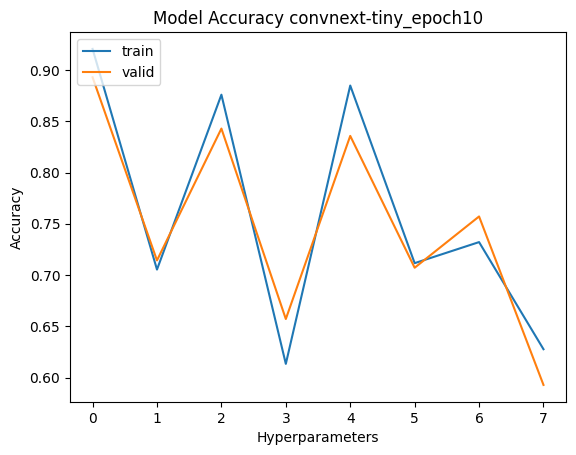

In [18]:
plt.plot([i for i in df_trainingresult.avg_train_acc])
plt.plot([i for i in df_trainingresult.avg_val_acc])
plt.title('Model Accuracy convnext-tiny_epoch10')
plt.ylabel('Accuracy')
plt.xlabel('Hyperparameters')
plt.legend(['train', 'valid'], loc='upper left')
plt.show()

In [29]:
bestmodel = df_trainingresult.query('avg_val_acc == avg_val_acc.max()')
bestmodel

,batch_size,learning_rate,model,train_acc_hist,val_acc_hist,avg_train_acc,avg_val_acc
0,8.0,0.0001,ConvNeXt(\n (downsample_layers): ModuleList(\...,"[tensor(0.6875, dtype=torch.float64), tensor(0...","[tensor(0.7143, dtype=torch.float64), tensor(0...",0.920536,0.892857


* convnext-tiny_batch8_lr01e-3_epoch10

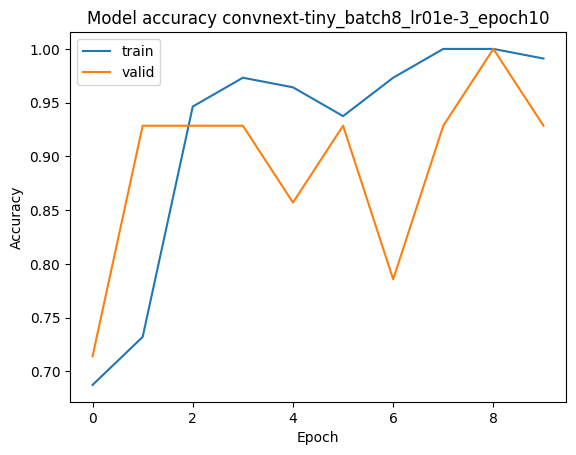

In [60]:
#modelbest, train_accbest, val_accbest = train_model_hyperparameter(df_train, df_val, 8, 0.1e-3, 10)
modelbest = bestmodel['model'][0]
#torch.save(model_ft.state_dict(), '../watermarkmodel/model/weights/convnext-tiny_watermarks_detector_datav1_batch8_lr02e-5_epoch10.pth')
plt.plot([i.cpu().item() for i in bestmodel.train_acc_hist[0]])
plt.plot([i.cpu().item() for i in bestmodel.val_acc_hist[0]])
plt.title('Model accuracy convnext-tiny_batch8_lr01e-3_epoch10')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['train', 'valid'], loc='upper left')
plt.show()

**training with untrained convnext**

In [ ]:
import warnings
warnings.filterwarnings("ignore")
from watermarkmodel.model.convnext import convnext_tiny

model_ft = convnext_tiny(pretrained=False, in_22k=True, num_classes=21841)

#config
criterion = torch.nn.CrossEntropyLoss()
optimizer = optim.AdamW(params=model_ft.parameters(), lr=0.1e-3)
BATCH_SIZE = 16
dataloaders_dict = {
    x: torch.utils.data.DataLoader(datasets[x], batch_size=BATCH_SIZE, shuffle=True, num_workers=0) #to prevent runtimeerror on non gpu device
    for x in ['train', 'val']
    }

model_ft.head = nn.Sequential( 
    nn.Linear(in_features=768, out_features=512),
    nn.GELU(),
    nn.Linear(in_features=512, out_features=256),
    nn.GELU(),
    nn.Linear(in_features=256, out_features=2),
)

model_ft, train_acc_history, val_acc_history = train_model(
    model_ft, dataloaders_dict, criterion, optimizer, num_epochs=10
)

Epoch 0/4
----------


100%|██████████| 7/7 [01:18<00:00, 11.19s/it]


train Loss: 0.6265 Acc: 0.6071


100%|██████████| 1/1 [00:01<00:00,  1.55s/it]


val Loss: 0.6402 Acc: 0.5714

Epoch 1/4
----------


100%|██████████| 7/7 [01:06<00:00,  9.54s/it]


train Loss: 0.5877 Acc: 0.7232


100%|██████████| 1/1 [00:01<00:00,  1.71s/it]


val Loss: 0.6490 Acc: 0.5714

Epoch 2/4
----------


100%|██████████| 7/7 [00:57<00:00,  8.21s/it]


train Loss: 0.5707 Acc: 0.7321


100%|██████████| 1/1 [00:01<00:00,  1.56s/it]


val Loss: 0.6605 Acc: 0.5714

Epoch 3/4
----------


100%|██████████| 7/7 [00:52<00:00,  7.51s/it]


train Loss: 0.5621 Acc: 0.7321


100%|██████████| 1/1 [00:01<00:00,  1.91s/it]


val Loss: 0.6604 Acc: 0.5714

Epoch 4/4
----------


100%|██████████| 7/7 [00:50<00:00,  7.26s/it]


train Loss: 0.5443 Acc: 0.7411


100%|██████████| 1/1 [00:01<00:00,  1.53s/it]

val Loss: 0.6804 Acc: 0.5714

Training complete in 5m 14s
Best val Acc: 0.571429


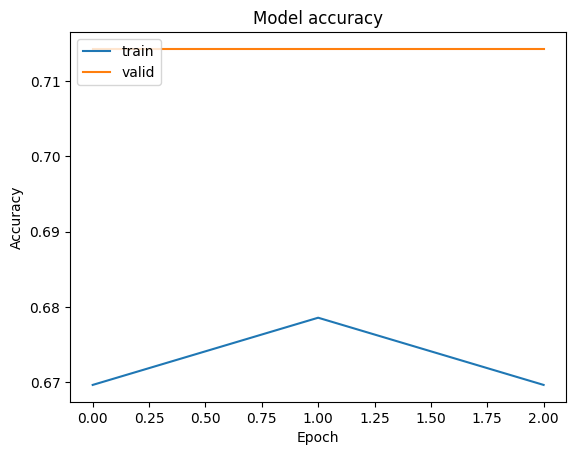

In [ ]:
plt.plot([i.cpu().item() for i in train_acc_history])
plt.plot([i.cpu().item() for i in val_acc_history])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['train', 'valid'], loc='upper left')
torch.save(model_ft.state_dict(), '../watermarkmodel/model/weights/convnext-tiny_watermarks_detector_data_v1_untrained.pth')
plt.show()

**training with resnet model**

In [ ]:
import warnings
warnings.filterwarnings("ignore")

model_ft = models.resnext50_32x4d(pretrained=True)
num_ftrs = model_ft.fc.in_features
model_ft.fc = nn.Linear(num_ftrs, 2)

model_ft, train_acc_history, val_acc_history = train_model(
    model_ft, dataloaders_dict, criterion, optimizer, num_epochs=10
)

Epoch 0/9
----------


100%|██████████| 2/2 [02:05<00:00, 62.54s/it]


train Loss: 0.6809 Acc: 0.6071


100%|██████████| 1/1 [00:02<00:00,  2.03s/it]


val Loss: 0.6360 Acc: 0.6429

Epoch 1/9
----------


100%|██████████| 2/2 [01:41<00:00, 50.56s/it]


train Loss: 0.6696 Acc: 0.5625


100%|██████████| 1/1 [00:01<00:00,  1.92s/it]


val Loss: 0.6361 Acc: 0.6429

Epoch 2/9
----------


100%|██████████| 2/2 [01:38<00:00, 49.30s/it]


train Loss: 0.6850 Acc: 0.5893


100%|██████████| 1/1 [00:01<00:00,  1.80s/it]


val Loss: 0.6360 Acc: 0.6429

Epoch 3/9
----------


100%|██████████| 2/2 [01:28<00:00, 44.26s/it]


train Loss: 0.6719 Acc: 0.5804


100%|██████████| 1/1 [00:01<00:00,  1.76s/it]


val Loss: 0.6370 Acc: 0.6429

Epoch 4/9
----------


100%|██████████| 2/2 [01:30<00:00, 45.15s/it]


train Loss: 0.6704 Acc: 0.6071


100%|██████████| 1/1 [00:02<00:00,  2.02s/it]


val Loss: 0.6400 Acc: 0.6429

Epoch 5/9
----------


100%|██████████| 2/2 [01:43<00:00, 51.89s/it]


train Loss: 0.6736 Acc: 0.6518


100%|██████████| 1/1 [00:01<00:00,  1.82s/it]


val Loss: 0.6442 Acc: 0.6429

Epoch 6/9
----------


100%|██████████| 2/2 [52:46<00:00, 1583.49s/it]


train Loss: 0.6750 Acc: 0.6339


100%|██████████| 1/1 [00:10<00:00, 10.52s/it]


val Loss: 0.6472 Acc: 0.7143

Epoch 7/9
----------


100%|██████████| 2/2 [03:10<00:00, 95.10s/it] 


train Loss: 0.6788 Acc: 0.5536


100%|██████████| 1/1 [00:02<00:00,  2.72s/it]


val Loss: 0.6497 Acc: 0.7143

Epoch 8/9
----------


100%|██████████| 2/2 [33:15<00:00, 997.76s/it] 


train Loss: 0.6735 Acc: 0.5446


100%|██████████| 1/1 [00:03<00:00,  3.43s/it]


val Loss: 0.6507 Acc: 0.7143

Epoch 9/9
----------


100%|██████████| 2/2 [02:17<00:00, 68.80s/it]


train Loss: 0.6638 Acc: 0.6518


100%|██████████| 1/1 [00:03<00:00,  3.14s/it]

val Loss: 0.6535 Acc: 0.7143

Training complete in 102m 10s
Best val Acc: 0.714286


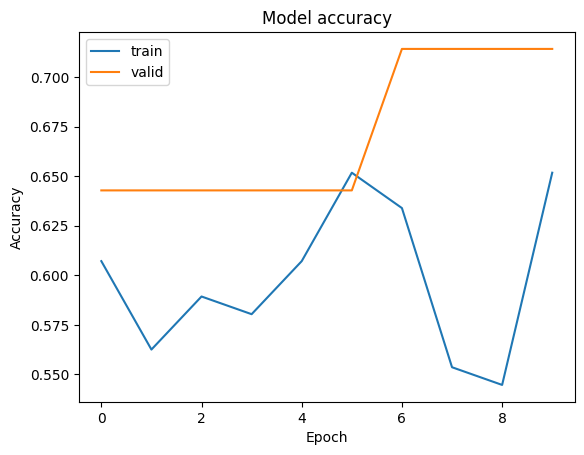

In [ ]:
plt.plot([i.cpu().item() for i in train_acc_history])
plt.plot([i.cpu().item() for i in val_acc_history])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['train', 'valid'], loc='upper left')
plt.show()

In [ ]:
os.makedirs('../watermarkmodel/model/weights', exist_ok=True)
torch.save(model_ft.state_dict(), "../weights/resnext-t_3layer-head_inp256_datasetv1-1_10epochs_v3.pth")

## create model pickle from the best result **(pretrained_batch8_lr01e-3_epoch5)**

In [39]:
import pickle

#save model
filename = 'watermark_model.pkl'
pickle.dump(modelbest, open(filename, 'wb'))
print('done')

done


## model evaluation

**(pretrained_batch8_lr01e-3_epoch10)**

In [40]:
import warnings
warnings.filterwarnings("ignore")
from PIL import Image
from watermarkmodel.utils import list_images
from watermarkmodel.model import get_convnext_model
from watermarkmodel.model.predictor import WatermarksPredictor
import pandas as pd
import pickle

#validation data
images = list_images('../images/test_images/') 

pkl_filename = "watermark_model.pkl"
with open(pkl_filename, 'rb') as f_in:
    modelpkl = pickle.load(f_in)

transforms = get_convnext_model('convnext-tiny')[1]
predictor = WatermarksPredictor(modelpkl, transforms, 'cpu')
result = predictor.run(images)
#result
print('done')

  0%|          | 0/2 [00:00<?, ?it/s]/Users/atsiri/.pyenv/versions/3.9.13/lib/python3.9/site-packages/timm/models/layers/__init__.py:48: FutureWarning: Importing from timm.models.layers is deprecated, please import via timm.layers
  warnings.warn(f"Importing from {__name__} is deprecated, please import via timm.layers", FutureWarning)
/Users/atsiri/.pyenv/versions/3.9.13/lib/python3.9/site-packages/timm/models/layers/__init__.py:48: FutureWarning: Importing from timm.models.layers is deprecated, please import via timm.layers
  warnings.warn(f"Importing from {__name__} is deprecated, please import via timm.layers", FutureWarning)
/Users/atsiri/.pyenv/versions/3.9.13/lib/python3.9/site-packages/timm/models/layers/__init__.py:48: FutureWarning: Importing from timm.models.layers is deprecated, please import via timm.layers
  warnings.warn(f"Importing from {__name__} is deprecated, please import via timm.layers", FutureWarning)
/Users/atsiri/.pyenv/versions/3.9.13/lib/python3.9/site-package

done


In [41]:
df_testcsv = pd.read_csv('../dataset/test_data_v1.csv')
df_testcsv['filename'] = df_testcsv['path'].apply(os.path.basename)

df_testresult = pd.DataFrame(list(zip(images, result)), columns=['path', 'prediction'])
df_testresult['filename'] = df_testresult['path'].apply(os.path.basename)

df_result = df_testcsv.merge(df_testresult, left_on='filename', right_on='filename')[['filename', 'label', 'prediction']]
accuracy = df_result[df_result.label == df_result.prediction]['filename'].count() / len(df_result) * 100
print('accuracy :', accuracy, '%') 

#rename label
df_result

accuracy : 93.33333333333333 %


,filename,label,prediction
0,DuVNMUdGvUdXeUHu.jpg,0,1
1,X8rMOlzQ5VhObWBA.jpg,0,0
2,wF36fOb5YWatHBJk.jpg,0,0
3,L4y4OQDGkz3m05im.jpg,1,1
4,DVHJaVOChW1VeEjx.jpg,0,0
5,sdnWkimhMDNOzR4r.jpg,0,0
6,fnnKTFUx36makePy.jpg,0,0
7,zwiv9icUoyXjZ3zv.jpg,1,1
8,CnJAPSZ7zrR3Sqxv.jpg,0,0
9,uU50iJIBiV1h40Pq.jpg,0,0


- precision:  1.0 
- recall: 0.9


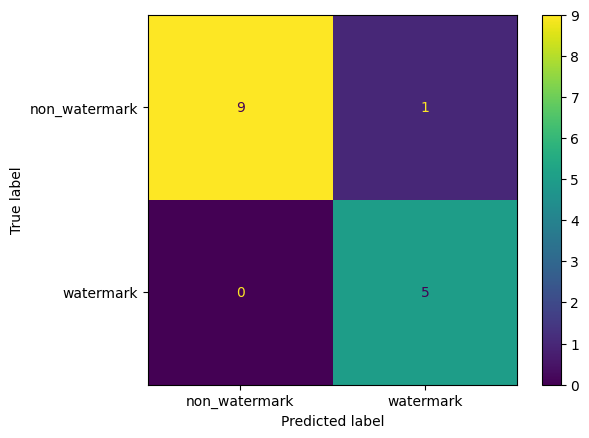

In [55]:
from watermarkmodel.model.metrics import plot_confusion_matrix

confmatrix = plot_confusion_matrix(df_result['label'].values, df_result['prediction'].values)
print('- precision: ', confmatrix[1][0], '\n- recall:', confmatrix[2][0])
confmatrix[0].plot().figure_.savefig('confusion_matrix.png')

In [50]:
confmatrix#].savefig('confusion_matrix.png')

(<sklearn.metrics._plot.confusion_matrix.ConfusionMatrixDisplay at 0x15e725df0>,
 array([1.        , 0.83333333]),
 array([0.9, 1. ]))

In [53]:
confmatrix[0].figure_.savefig('confusion_matrix.png')

**Evaluate Model Function**

In [72]:
from PIL import Image
from watermarkmodel.utils import list_images
from watermarkmodel.model import get_convnext_model
from watermarkmodel.model.predictor import WatermarksPredictor
from watermarkmodel.model.metrics import plot_confusion_matrix

def evaluate_ml_model(picklefile, imagefolder):
    images = list_images(imagefolder) 
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    filename = picklefile
    with open(filename, 'rb') as f_in:
        modelpkl = pickle.load(f_in)

    transforms = get_convnext_model('convnext-tiny')[1]
    predictor = WatermarksPredictor(modelpkl, transforms, device)
    result = predictor.run(images)

    df_testcsv = pd.read_csv('../dataset/test_data_v1.csv')
    df_testcsv['filename'] = df_testcsv['path'].apply(os.path.basename)

    df_testresult = pd.DataFrame(list(zip(images, result)), columns=['path', 'prediction'])
    df_testresult['filename'] = df_testresult['path'].apply(os.path.basename)

    df_result = df_testcsv.merge(df_testresult, left_on='filename', right_on='filename')[['filename', 'label', 'prediction']]
    accuracy = df_result[df_result.label == df_result.prediction]['filename'].count() / len(df_result) * 100

    #metric result
    confmatrix = plot_confusion_matrix(df_result['label'].values, df_result['prediction'].values)
    precision = confmatrix[1][0]
    recall = confmatrix[2][0]
    figures = confmatrix[0].plot()#figure_.savefig('confusion_matrix.png')

    return precision, recall, accuracy, figures

  0%|          | 0/2 [00:00<?, ?it/s]/Users/atsiri/.pyenv/versions/3.9.13/lib/python3.9/site-packages/timm/models/layers/__init__.py:48: FutureWarning: Importing from timm.models.layers is deprecated, please import via timm.layers
  warnings.warn(f"Importing from {__name__} is deprecated, please import via timm.layers", FutureWarning)
/Users/atsiri/.pyenv/versions/3.9.13/lib/python3.9/site-packages/timm/models/layers/__init__.py:48: FutureWarning: Importing from timm.models.layers is deprecated, please import via timm.layers
  warnings.warn(f"Importing from {__name__} is deprecated, please import via timm.layers", FutureWarning)
/Users/atsiri/.pyenv/versions/3.9.13/lib/python3.9/site-packages/timm/models/layers/__init__.py:48: FutureWarning: Importing from timm.models.layers is deprecated, please import via timm.layers
  warnings.warn(f"Importing from {__name__} is deprecated, please import via timm.layers", FutureWarning)
/Users/atsiri/.pyenv/versions/3.9.13/lib/python3.9/site-package

precision: 1.0
recall: 0.9
accuracy 93.33333333333333


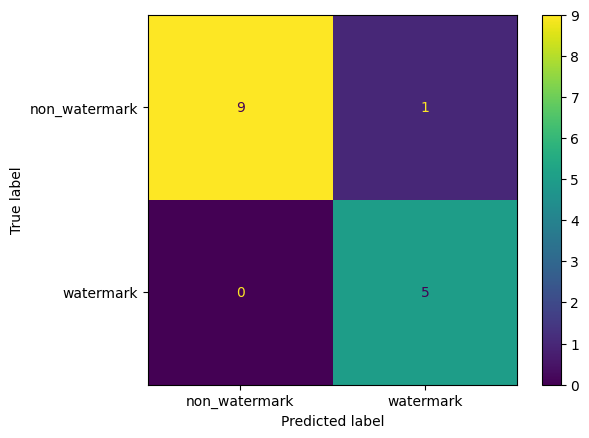

In [73]:
precision, recall, accuracy, figures = evaluate_ml_model('watermark_model.pkl', '../images/test_images/')
print('precision:', precision)
print('recall:', recall)
print('accuracy', accuracy)
figures.figure_.savefig('confusion_matrix.png')